### this notebook is used for OB data processing

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy import stats
import pynapple as nap

In [55]:
## OB data processing

def get_PETH_dict_ob(neuron_matrix,neuron_timestamps,slow_milk_ts_clean):
    from scipy import stats
    ## now generate PSTH for each cell
    windowsize = 10 # sec, before + after the given timestamps
    half_window = int(windowsize/2)
    num_bins = windowsize * 10 # based on 10 Hz
    # t_scale = np.linspace(-5,5,num_bins)
    PETH_trace_milk = {}
    neuron_matrix = pd.DataFrame(neuron_matrix.T,index=neuron_timestamps) 
    neuron_matrix_z = neuron_matrix.apply(stats.zscore,axis=0,nan_policy='omit')

    cellset = neuron_matrix_z.columns
    # cellset = df_accepted.columns

    for cell in cellset:
        PETH_trace = np.zeros([len(slow_milk_ts_clean),num_bins])
        
        for trial, time in enumerate(slow_milk_ts_clean):
            value = neuron_matrix_z[cell][time-half_window:time+half_window].values
            while len(value)<num_bins:
                # print(trial,time)
                # print('add nan to last part')
                value = np.pad(value, (0, 1), 'constant', constant_values=(np.nan,np.nan))
            else:
                PETH_trace[trial,:] = value[0:num_bins] # keep the slicer here so in case we got one more value here
        PETH_trace_milk[cell] = PETH_trace
    return PETH_trace_milk


### OB data loading
## Setting for OB plotting
import pickle
def  loaddicti (name):
    # fileo =  open("/Users/hunglo/Documents/inscopix_csv/OB_2P_data/dictionariesneurocorr/"+name+".pickle", 'rb')
    # fileo =  open("/Users/hunglo/Documents/inscopix_csv/OB_2P_data/dictionariesneurocorrzscore/"+name+".pickle", 'rb')
    fileo =  open("/Users/hunglo/Documents/inscopix_csv/OB_2P_data/dict_hung/"+name+".pickle", 'rb')
    # fileo= open("/content/drive/My Drive/inscopix_csv/OB_2P_data/dictionariesneurocorr/"+name+".pickle", 'rb')
    dictio=pickle.load(fileo)
    return dictio

## auroc for OB data, do auROC calculation individually in for loop structure
## function for calculate auroc for slow feeding events

def cal_auroc_OB(PETH_single_cell,steps=20):
   from sklearn.metrics import auc
   data = PETH_single_cell
   if PETH_single_cell.shape[1] == 50:  
     baseline = data[:,0:10].flatten()
   else:
     baseline = data[:,40:50].flatten()
   baseline = baseline[~np.isnan(baseline)] # remove nan values
   auc_concat = []
   for i in range(data.shape[1]):
     auc_ = []
     stimulus = data[:,i]
     stimulus = stimulus[~np.isnan(stimulus)] # remove nan values
     pool = [*baseline, *stimulus]
     steps = steps
     criteria = [min(pool) + (j*(max(pool)-min(pool))/steps) for j in range(steps)]
     criteria[0] = criteria[0] - 1e-12 # modify the min value to slighter lesser value, so baseline/stimulus will be larger than the min of criteria
     pbase = []
     pstim = []
     # Calculate P(above threshold) for each cutoff
     for cri in criteria:
      pbase.append(sum(baseline > cri)/len(baseline))
      pstim.append(sum(stimulus > cri)/len(stimulus))
     auc_ = auc(x = pbase, y = pstim)
     auc_concat.append(auc_)
   auc_concat = np.array(auc_concat)
   return auc_concat

def cell_class_OB(auroc,window=2,threshold_sd=3.5):
   idx_positive = []
   idx_negative = []
   frate = 10
   for idx in range(auroc.shape[0]):
    threshold_high = np.mean(auroc[idx,0:10]) + np.std(auroc[idx,0:10])*threshold_sd
    auroc_temp = auroc[idx].copy()
    j_temp = []
    for j in range(10,10+window*frate):  # Only look at first 2 sec after delivery (the window size)
        if auroc_temp[j] > threshold_high:
           j_temp.append(j)
    if j_temp !=[]:
        if checkConsecutive(j_temp,n=3) == True:
           idx_positive.append(idx)
      # print('# {} is responding to milk'.format(idx))
   for idx in range(auroc.shape[0]):
    threshold_high = np.mean(auroc[idx,0:10]) - np.std(auroc[idx,0:10])*threshold_sd
    auroc_temp = auroc[idx].copy()
    j_temp = []
    for j in range(10,10+window*frate):  # Only look at first 2 sec after delivery (the window size)
        if auroc_temp[j] < threshold_high:
           j_temp.append(j)
    if j_temp !=[]:
        if checkConsecutive(j_temp,n=3) == True:
           idx_negative.append(idx)
      # print('# {} is responding to milk'.format(idx))
   ## make idx for non-responding neurons
   cellnum = auroc.shape[0]
   idx_non = []
   idx_non = [i for i in range(cellnum) if i not in idx_positive and i not in idx_negative]
   return idx_positive, idx_negative, idx_non


def cell_class_OB_new(auroc,window=2,threshold_sd=3.5):
   idx_positive = []
   idx_negative = []
   frate = 10
   for idx in range(auroc.shape[0]):
    threshold_high = np.mean(auroc[idx,40:50]) + np.std(auroc[idx,40:50])*threshold_sd
    auroc_temp = auroc[idx].copy()
    j_temp = []
    for j in range(10,10+window*frate):  # Only look at first 2 sec after delivery (the window size)
        if auroc_temp[j] > threshold_high:
           j_temp.append(j)
    if j_temp !=[]:
        if checkConsecutive(j_temp,n=3) == True:
           idx_positive.append(idx)
      # print('# {} is responding to milk'.format(idx))
   for idx in range(auroc.shape[0]):
    threshold_high = np.mean(auroc[idx,40:50]) - np.std(auroc[idx,40:50])*threshold_sd
    auroc_temp = auroc[idx].copy()
    j_temp = []
    for j in range(10,10+window*frate):  # Only look at first 2 sec after delivery (the window size)
        if auroc_temp[j] < threshold_high:
           j_temp.append(j)
    if j_temp !=[]:
        if checkConsecutive(j_temp,n=3) == True:
           idx_negative.append(idx)
      # print('# {} is responding to milk'.format(idx))
   ## make idx for non-responding neurons
   cellnum = auroc.shape[0]
   idx_non = []
   idx_non = [i for i in range(cellnum) if i not in idx_positive and i not in idx_negative]
   return idx_positive, idx_negative, idx_non


def detect_binge_bout(Pump1,interval=3):
    Pump1 = np.pad(Pump1, (1, 1), 'constant', constant_values=(0,Pump1.max()+interval*10)) # so the last value is more than interval
    diff = Pump1[1:]-Pump1[:-1]
    gap = diff>interval # binary data
    idx = np.where(gap == 1) # idx == 1
    start_concat, end_concat = [],[]
    for idx_ in idx:
        start_concat.append(Pump1[1:][idx_])
        end_concat.append(Pump1[:][idx_])
    start_concat = start_concat[0][:-1] # remove empty starting
    end_concat = end_concat[0][1:] # remove empty ending

    binge_epoch = nap.IntervalSet(start_concat,end_concat)

    ## run through the rows to make sure there isn't no duration epochs
    ## note this should be taken care of from the pynapple package but somehow it isn't working properly 
    binge_epoch_clean = pd.DataFrame(data=[], columns=['start','end'])
    for n in range(binge_epoch.shape[0]):
        for x,y in binge_epoch[n:n+1].values:
            # print(x,y)
            # if x!= y: ## this is the old alg
            if y-x >3: # at least 3 sec bout
            # if True:
                binge_epoch_clean = pd.concat([binge_epoch_clean,binge_epoch[n:n+1]])
    binge_epoch_clean = nap.IntervalSet(binge_epoch_clean['start'],binge_epoch_clean['end'], time_units='s')
    return binge_epoch_clean


def dict2np(PETH):

    keys = list(PETH.keys())

    if len(keys) == 0:
        return None
    else:
        dat_temp = PETH.get(keys[0])
        PETH_new = np.zeros((len(keys),dat_temp.shape[0],dat_temp.shape[1]))
        for idx,cell in enumerate(keys):
            PETH_new[idx,:,:] = PETH[cell]
        return PETH_new

In [56]:
## load the data matrix from F 

import pickle
name = 'everysingleexp'
fileo =  open("/Users/hunglo/Documents/inscopix_csv/OB_2P_data/dictionariesneurocorrzscore/"+name+".pickle", 'rb')
dictio = pickle.load(fileo)

## get mouse id list
mouse_id_list = sorted(list(dictio.keys()))

mouse_id = mouse_id_list[0] # use first mouse as example

## generate a df contain all exp dates

df_exp = pd.DataFrame([])

for mouse_id in mouse_id_list:
    ## get date list for each mouse
    date_list = sorted(list(dictio.get(mouse_id).keys()))

    ## check if on this mouse/date is an empty dict (no recording found)
    for date in date_list:
        if dictio.get(mouse_id).get(date) == {}:
            pass
            # print(f"no recording data on {mouse_id} {date}")
        else:
            # print(f"yes recording data on {mouse_id} {date}")
            exp_list = sorted(list(dictio.get(mouse_id).get(date).keys()))
            counter = []
            binge_counter,slow_counter = 0,0

            for exp in exp_list:
                ## let's only work on data where both fast and slow, so the sum of fast and slow protocol should all be more than 0
                if (sum(['fast' in exp for exp in exp_list])>0) & (sum(['slow' in exp for exp in exp_list])>0):
                    ## check size of neuromatix ([4] item in exp), make sure it's not zero
                    if dictio.get(mouse_id).get(date).get(exp)[4][0].shape[1] != 0:
                        if 'fast' in exp:
                            feeding_type = 'binge'
                            binge_counter += 1
                            counter = binge_counter
                        else:
                            feeding_type = 'slow'
                            slow_counter += 1
                            counter = slow_counter
                        df_exp = pd.concat([df_exp,pd.DataFrame({"mouse_id":[mouse_id],"date":[date],"feeding_type":[feeding_type],"exp":[exp],"counter":counter})])

df_exp = df_exp.reset_index(drop=True)
df_exp



,mouse_id,date,feeding_type,exp,counter
0,SNA095265,211119,slow,138slowfor2P.xlsx_slow,1
1,SNA095265,211119,binge,152fastfor2P.xlsx_fast,1
2,SNA095265,211119,slow,1slowfor2P.xlsx_slow,2
3,SNA095265,211119,binge,26fastfor2P.xlsx_fast,2
4,SNA095265,211119,binge,96fastfor2P.xlsx_fast,3
...,...,...,...,...,...
105,SNA095270,211124,binge,141fastfor2P.xlsx_fast,1
106,SNA095270,211124,slow,431slowfor2P.xlsx_slow,1
107,SNA095270,211124,slow,50-102_slow,2
108,SNA095270,211124,binge,504fastfor2P.xlsx_fast,2


In [63]:
## now we can iterate through each row and base on feeding type do different alignment

PETH_trace_slow, PETH_trace_binge = {},{}

Pump_event_list = [] # append a list of True/False so that we know which exp actually has feeding events

for row in df_exp.iterrows():
    mouse_id = row[1]['mouse_id']
    date = row[1]['date']
    exp  = row[1]['exp']
    feeding_type = row[1]['feeding_type']
    counter = row[1]['counter']

    licks = np.array(dictio.get(mouse_id).get(date).get(exp)[2])
    ## add a far behind lick event in the end of the trial, so the conditions will be fullfill
    licks = np.pad(licks,(0,1),mode='constant',constant_values=(np.nan, 2000))
    ## pump event
    pumps = np.array(dictio.get(mouse_id).get(date).get(exp)[0])
    binge_epoch_clean = np.array([]) ## init here for condiitoning later
    neuron_matrix = dictio.get(mouse_id).get(date).get(exp)[4][0] ## organized in neurons * timestamps (frames, frame rate is 10 Hz)
    neuron_timestamps = dictio.get(mouse_id).get(date).get(exp)[4][1] ## time stamps from the recording (10 Hz but with actual jitters)
    timestamp_reference = [] # init time reference

    ## find slow exps in exp name 
    if feeding_type == 'slow':
        ## make sure there are lick events after pump delivery in 4 sec
        ## for binge eating we are guaranteed to have licks after due to the binge detection function, so we don't need to worry about this
        pumps_clean = np.array([p for p in pumps if (licks[licks>p][0]-p)<4])
        timestamp_reference = pumps_clean

    ## same for binge exps, but the timestamp reference here are the binge bout onsets
    else:
        pumps_clean = pumps
        binge_epoch_clean = detect_binge_bout(pumps_clean)
        timestamp_reference = binge_epoch_clean['start'].values

    ## now do PETH here with timestamp_reference
    if len(timestamp_reference) != 0: # if there is reference timepoint to align to
        PETH_trace = []
        PETH_trace = get_PETH_dict_ob(neuron_matrix,neuron_timestamps,timestamp_reference)
        PETH_trace = dict2np(PETH_trace)
        # print(date, exp, timestamp_reference)
        Pump_event_list.append(True)

        ## loop through each neuron and convert it to pd DataFrame by row=timestamp (in index) , col=trials 
        if 'slow' in exp:
            PETH_trace_slow[f'{mouse_id}_{date}_{feeding_type}_{counter}']  = PETH_trace
        elif 'fast' in exp:
            PETH_trace_binge[f'{mouse_id}_{date}_{feeding_type}_{counter}'] = PETH_trace
        else:
            print("check script again, if works it shouldn't lead to here")
    else:
        print(f"no eating event in {mouse_id} {date} {exp}")
        Pump_event_list.append(False)
    
PETH_trace_binge.keys()


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/panda

no eating event in SNA095265 211119 152fastfor2P.xlsx_fast
no eating event in SNA095265 211122 267fastfor2P.xlsx_fast
no eating event in SNA095265 211123 103fastfor2P.xlsx_fast
no eating event in SNA095265 211123 148fastfor2P.xlsx_fast
no eating event in SNA095265 211123 1slowfor2P.xlsx_slow


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))


no eating event in SNA095266 211116 7180-102,123-102_fast


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))


no eating event in SNA095266 211117 559fastfor2P.xlsx_fast
no eating event in SNA095266 211119 907fastfor2P.xlsx_fast
no eating event in SNA095266 211122 1slowfor2P.xlsx_slow


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)


no eating event in SNA095266 211122 606fastfor2P.xlsx_fast
no eating event in SNA095266 211123 452fastfor2P.xlsx_fast


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_859

no eating event in SNA095267 211122 256fastfor2P.xlsx_fast
no eating event in SNA095267 211122 268fastfor2P.xlsx_fast
no eating event in SNA095267 211122 280fastfor2P.xlsx_fast
no eating event in SNA095267 211123 298fastfor2P.xlsx_fast


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.p

no eating event in SNA095270 211118 146fastfor2P.xlsx_fast
no eating event in SNA095270 211118 14slowfor2P.xlsx_slow


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: User

dict_keys(['SNA095265_211119_binge_2', 'SNA095265_211119_binge_3', 'SNA095265_211122_binge_1', 'SNA095265_211122_binge_3', 'SNA095265_211124_binge_1', 'SNA095265_211124_binge_2', 'SNA095265_211124_binge_3', 'SNA095266_211116_binge_1', 'SNA095266_211116_binge_3', 'SNA095266_211116_binge_4', 'SNA095266_211117_binge_1', 'SNA095266_211119_binge_1', 'SNA095266_211119_binge_2', 'SNA095266_211119_binge_4', 'SNA095266_211122_binge_1', 'SNA095266_211122_binge_2', 'SNA095266_211123_binge_1', 'SNA095266_211123_binge_3', 'SNA095266_211123_binge_4', 'SNA095266_211124_binge_1', 'SNA095266_211124_binge_2', 'SNA095266_211124_binge_3', 'SNA095267_211118_binge_1', 'SNA095267_211118_binge_2', 'SNA095267_211119_binge_1', 'SNA095267_211119_binge_2', 'SNA095267_211119_binge_3', 'SNA095267_211122_binge_4', 'SNA095267_211123_binge_1', 'SNA095267_211123_binge_3', 'SNA095270_211116_binge_1', 'SNA095270_211118_binge_2', 'SNA095270_211118_binge_3', 'SNA095270_211118_binge_4', 'SNA095270_211119_binge_1', 'SNA09527

In [64]:
df_exp['Eating events'] = Pump_event_list
df_exp

,mouse_id,date,feeding_type,exp,counter,Eating events
0,SNA095265,211119,slow,138slowfor2P.xlsx_slow,1,True
1,SNA095265,211119,binge,152fastfor2P.xlsx_fast,1,False
2,SNA095265,211119,slow,1slowfor2P.xlsx_slow,2,True
3,SNA095265,211119,binge,26fastfor2P.xlsx_fast,2,True
4,SNA095265,211119,binge,96fastfor2P.xlsx_fast,3,True
...,...,...,...,...,...,...
105,SNA095270,211124,binge,141fastfor2P.xlsx_fast,1,True
106,SNA095270,211124,slow,431slowfor2P.xlsx_slow,1,True
107,SNA095270,211124,slow,50-102_slow,2,True
108,SNA095270,211124,binge,504fastfor2P.xlsx_fast,2,True


In [65]:
### move the single cell extraction outside the loop

name = 'everysingleexp'
# fileo =  open("/Users/hunglo/Documents/inscopix_csv/OB_2P_data/dictionaries/"+name+".pickle", 'rb')
# fileo =  open("/Users/hunglo/Documents/inscopix_csv/OB_2P_data/dictionariesneurocorr/"+name+".pickle", 'rb')
fileo =  open("/Users/hunglo/Documents/inscopix_csv/OB_2P_data/dictionariesneurocorrzscore/"+name+".pickle", 'rb')

dictio=pickle.load(fileo)

mouse_id_list = sorted(dictio.keys())
# mouse_id_list = sorted(mouse_id_list)

PETH_trace_slow = {}
PETH_trace_binge = {}

for mouse_id in mouse_id_list[:]:
    ## get date list from each mouse
    date_list = sorted(list(dictio.get(mouse_id).keys()))
    for date in date_list[:]:
        print(f"{mouse_id} {date}")

        ## make sure under the date dictionary there is any data
        if dictio.get(mouse_id).get(date) is not None:
            slow_count, binge_count = 0,0
            exp_list = sorted(list(dictio.get(mouse_id).get(date).keys()))

            ## loop through each experiments on this date
            for exp in exp_list:
                print(f"{mouse_id} {date} {exp}")
                ## check if this exp there is no recording
                if dictio.get(mouse_id).get(date).get(exp)[4][0].shape[1] != 0: 
                    print(f"   {dictio.get(mouse_id).get(date).get(exp)[4][0].shape}") # checking neuron matrix size (neurons * time)
                    ## do actual extraction here:
                    ## lick event
                    licks = np.array(dictio.get(mouse_id).get(date).get(exp)[2])
                    ## add a far behind lick event in the end of the trial, so the conditions will be fullfill
                    licks = np.pad(licks,(0,1),mode='constant',constant_values=(np.nan, 2000))
                    ## pump event
                    pumps = np.array(dictio.get(mouse_id).get(date).get(exp)[0])
                    binge_epoch_clean = np.array([]) ## init here for condiitoning later
                    neuron_matrix = dictio.get(mouse_id).get(date).get(exp)[4][0] ## organized in neurons * timestamps (frames, frame rate is 10 Hz)
                    neuron_timestamps = dictio.get(mouse_id).get(date).get(exp)[4][1] ## time stamps from the recording (10 Hz but with actual jitters)
                    timestamp_reference = [] # init
                    ## find slow exps in exp name 
                    if 'slow' in exp:
                        feeding_type = 'slow'
                        ## make sure there are lick events after pump delivery in 4 sec
                        ## for binge eating we are guaranteed to have licks after due to the binge detection function, so we don't need to worry about this
                        pumps_clean = np.array([p for p in pumps if (licks[licks>p][0]-p)<4])
                        timestamp_reference = pumps_clean
                        exp_num = slow_count
                        slow_count +=1 # counter for later concatenation

                    ## same for binge exps, but the timestamp reference here are the binge bout onsets
                    elif 'fast' in exp: 
                        feeding_type = 'binge'
                        pumps_clean = pumps
                        ## only perform binge detection in fast 2p exp
                        binge_epoch_clean = detect_binge_bout(pumps_clean)
                        timestamp_reference = binge_epoch_clean['start'].values
                        exp_num = binge_count
                        binge_count +=1 # counter for later concatenation
                    else:
                        print(f"wrong exp name, recheck what is inside here {exp}")
                        ## do quick plotting here to see what's going on
                        plt.figure(figsize=[3,2])
                        plt.plot(np.nanmean(PETH_trace,axis=(0,1))) ## average trace of all neurons * trials
                        plt.axvline(x=50,ls=':',color='grey')
                        plt.title(f"{mouse_id}_{date}_{feeding_type}_{exp_num}")
                        plt.show()

                    ## now do PETH here with timestamp_reference
                    if len(timestamp_reference) != 0: # if there is not reference timepoint to align to
                        PETH_trace = []
                        PETH_trace = get_PETH_dict_ob(neuron_matrix,neuron_timestamps,timestamp_reference)
                        PETH_trace = dict2np(PETH_trace)
                        print(date, exp, timestamp_reference)

                        ## loop through each neuron and convert it to pd DataFrame by row=timestamp (in index) , col=trials 
                        if 'slow' in exp:
                            PETH_trace_slow[f'{mouse_id}_{date}_{feeding_type}_{exp_num}'] = PETH_trace
                        elif 'fast' in exp:
                            PETH_trace_binge[f'{mouse_id}_{date}_{feeding_type}_{exp_num}'] = PETH_trace
                        else:
                            print("check script again, if works it shouldn't lead to here")
                    else:
                        print(f"no eating event in {date} {exp}")
                        ## make empty array with matching neuron numbers in this recording session, for concatenation
                        ## trials with all nan will be removed when loading, so don't worry about that
                        PETH_trace = np.empty([neuron_matrix.shape[0],1,100]) 
                        PETH_trace[:] = np.nan
                        if 'slow' in exp:
                            PETH_trace_slow[f'{mouse_id}_{date}_{feeding_type}_{exp_num}'] = PETH_trace
                        elif 'fast' in exp:
                            PETH_trace_binge[f'{mouse_id}_{date}_{feeding_type}_{exp_num}'] = PETH_trace
                        else:
                            print("check script again, if works it shouldn't lead to here #2")
                    # plt.figure(figsize=[3,2])
                    # plt.plot(np.nanmean(PETH_trace,axis=(0,1))) ## average trace of all neurons * trials
                    # plt.axvline(x=50,ls=':',color='grey')
                    # plt.title(f"{mouse_id}_{date}_{feeding_type}_{exp_num}")
                    # plt.show()

                    ## now extract neurons from different exp and merge dataframes together for each cell
                    ## note this part should be outside the exp for loop so we can 
                    ## generate temp df for each neurons
                else:
                    print(f'   no exp for the given: {exp}')
            ## now we are done with each exp on each date, we can start generate neuromatrix on single cells

            ## (wait but can't I do this out of the loop? think again what's the point of doing it like this...)
            ## (cause we need to loop through the neurons on each date? but we can still access this info later right?)


        else:
            print(f'no recording on this date: {date}') 

## generate slow eating dictionary with dataframe of each neuron
# get number of neurons

PETH_trace_slow_all_single_neuron = {}
PETH_trace_binge_all_single_neuron = {}

all_cell_key_list = sorted(list(PETH_trace_slow.keys()))

for mouse_id in mouse_id_list[0:]:
    select_mouse_list = [key for key in all_cell_key_list if mouse_id in key]
    date_list = [select_key.split('_')[1] for select_key in select_mouse_list]
    date_list = sorted(list(set(date_list)))
    print(date_list)
    print(select_mouse_list)
    for date in date_list:
        print(date)
        select_exp_list = [select_key for select_key in select_mouse_list if date in select_key] # note we don't need the to check if there is slow
        print(select_exp_list)

        ## now loop through all exp on this date for slow exp
        num_neurons = [] # init
        num_neurons = PETH_trace_slow.get(select_exp_list[0]).shape[0]
        print(f"{mouse_id} {date} slow neurons={num_neurons}")
        if mouse_id=='SNA095270':
            if date == '211118':
                print('yes')

        ## loop through all neurons
        for i in range(num_neurons):
            df_temp = pd.DataFrame([],index=range(100))
            for exp in select_exp_list:
                df_temp = pd.concat([df_temp, pd.DataFrame(PETH_trace_slow.get(exp)[i].T)],axis=1)
            timestamp = pd.Series(np.arange(-5,5,0.1))
            df_temp = df_temp.set_index(timestamp)
            # plt.figure(figsize=[3,1])
            # plt.imshow(df_temp.T,aspect='auto')
            PETH_trace_slow_all_single_neuron[f"{mouse_id}{date}{i}"] = df_temp # save it for each neuron
        
                        

all_cell_key_list = sorted(list(PETH_trace_binge.keys()))

for mouse_id in mouse_id_list:
    select_mouse_list = [key for key in all_cell_key_list if mouse_id in key]
    date_list = [select_key.split('_')[1] for select_key in select_mouse_list]
    date_list = sorted(list(set(date_list)))
    print(date_list)
    print(select_mouse_list)
    for date in date_list:
        print(date)
        select_exp_list = [select_key for select_key in select_mouse_list if date in select_key] # note we don't need the to check if there is slow
        print(select_exp_list)

        ## now loop through all exp on this date for slow exp
        num_neurons = [] # init
        num_neurons = PETH_trace_binge.get(select_exp_list[0]).shape[0]
        print(f"{mouse_id} {date} slow neurons={num_neurons}")
        if mouse_id=='SNA095270':
            if date == '211118':
                print('yes')
        ## loop through all neurons
        for i in range(num_neurons):
            df_temp = pd.DataFrame([],index=range(100))
            for exp in select_exp_list:
                df_temp = pd.concat([df_temp, pd.DataFrame(PETH_trace_binge.get(exp)[i].T)],axis=1)
            timestamp = pd.Series(np.arange(-5,5,0.1))
            df_temp = df_temp.set_index(timestamp)
            PETH_trace_binge_all_single_neuron[f"{mouse_id}{date}{i}"] = df_temp # save it for each neuron


# Store data (serialize)
file_name = '/Users/hunglo/Documents/inscopix_csv/OB_2P_data/dict_hung/PSTHslow_2'
with open(f'{file_name}.pickle', 'wb') as handle:
    pickle.dump(PETH_trace_slow_all_single_neuron, handle, protocol=pickle.HIGHEST_PROTOCOL)

file_name = '/Users/hunglo/Documents/inscopix_csv/OB_2P_data/dict_hung/PSTHfast_2'
with open(f'{file_name}.pickle', 'wb') as handle:
    pickle.dump(PETH_trace_binge_all_single_neuron, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('all done and saved')

SNA095265 211116
SNA095265 211119
SNA095265 211119 138slowfor2P.xlsx_slow
   (47, 1200)
211119 138slowfor2P.xlsx_slow [30.132]
SNA095265 211119 152fastfor2P.xlsx_fast
   (47, 1200)
no eating event in 211119 152fastfor2P.xlsx_fast
SNA095265 211119 1slowfor2P.xlsx_slow
   (47, 1200)
211119 1slowfor2P.xlsx_slow [30.099998 44.577   ]
SNA095265 211119 26fastfor2P.xlsx_fast
   (47, 1200)
211119 26fastfor2P.xlsx_fast [30.138999]
SNA095265 211119 96fastfor2P.xlsx_fast
   (47, 1200)
211119 96fastfor2P.xlsx_fast [30.14]
SNA095265 211122
SNA095265 211122 207fastfor2P.xlsx_fast
   (39, 1200)
211122 207fastfor2P.xlsx_fast [30.138998]
SNA095265 211122 267fastfor2P.xlsx_fast
   (39, 1200)
no eating event in 211122 267fastfor2P.xlsx_fast
SNA095265 211122 77slowfor2P.xlsx_slow
   (39, 1200)


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/panda

211122 77slowfor2P.xlsx_slow [30.133002 35.737994]
SNA095265 211122 96fastfor2P.xlsx_fast
   (39, 1200)
211122 96fastfor2P.xlsx_fast [30.14]
SNA095265 211123
SNA095265 211123 103fastfor2P.xlsx_fast
   (37, 1200)
no eating event in 211123 103fastfor2P.xlsx_fast
SNA095265 211123 148fastfor2P.xlsx_fast
   (37, 1200)
no eating event in 211123 148fastfor2P.xlsx_fast
SNA095265 211123 14slowfor2P.xlsx_slow
   (37, 1200)
211123 14slowfor2P.xlsx_slow [41.027999]
SNA095265 211123 1slowfor2P.xlsx_slow
   (37, 1200)
no eating event in 211123 1slowfor2P.xlsx_slow
SNA095265 211124
SNA095265 211124 132slowfor2P.xlsx_slow
   (26, 1200)
211124 132slowfor2P.xlsx_slow [30.145996 34.520999 58.688997 86.031996]
SNA095265 211124 190fastfor2P.xlsx_fast
   (26, 1200)
211124 190fastfor2P.xlsx_fast [47.768996 56.369995 67.119995 81.698993]
SNA095265 211124 1fastfor2P.xlsx_fast
   (26, 1200)
211124 1fastfor2P.xlsx_fast [30.113    49.809997]
SNA095265 211124 285fastfor2P.xlsx_fast
   (26, 1200)
211124 285fastfor2

/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))


211116 248slowfor2P.xlsx_slow [30.080005 35.717    61.805998 66.256004 83.837004]
SNA095266 211116 334fastfor2P.xlsx_fast
   (51, 1200)
211116 334fastfor2P.xlsx_fast [30.078]
SNA095266 211116 628slowfor2P.xlsx_slow
   (51, 1200)
211116 628slowfor2P.xlsx_slow [30.081007 34.306001 51.757004 64.667005 83.947   ]
SNA095266 211116 7180-102,123-102_fast
   (51, 1200)
no eating event in 211116 7180-102,123-102_fast
SNA095266 211116 735fastfor2P.xlsx_fast
   (51, 1200)
211116 735fastfor2P.xlsx_fast [41.507    74.837001]
SNA095266 211116 915slowfor2P.xlsx_slow
   (51, 1200)
211116 915slowfor2P.xlsx_slow [30.087003 35.386001 70.509001 74.808005]
SNA095266 211116 976fastfor2P.xlsx_fast
   (51, 1200)
211116 976fastfor2P.xlsx_fast [75.705995]
SNA095266 211117
SNA095266 211117 1570-99_slow
   (62, 1200)


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))


211117 1570-99_slow [79.871002]
SNA095266 211117 378fastfor2P.xlsx_fast
   (62, 1200)
211117 378fastfor2P.xlsx_fast [40.435995 77.046   ]
SNA095266 211117 543slowfor2P.xlsx_slow
   (62, 1200)
211117 543slowfor2P.xlsx_slow [30.119999]
SNA095266 211117 559fastfor2P.xlsx_fast
   (62, 1200)
no eating event in 211117 559fastfor2P.xlsx_fast
SNA095266 211118
SNA095266 211118 419fastfor2P.xlsx_fast
   (43, 1200)
211118 419fastfor2P.xlsx_fast [30.148994 65.236    77.286   ]
SNA095266 211118 784fastfor2P.xlsx_fast
   (43, 1200)
211118 784fastfor2P.xlsx_fast [30.130004 49.096999 69.716998 85.735998]
SNA095266 211119
SNA095266 211119 137fastfor2P.xlsx_fast
   (50, 1200)
211119 137fastfor2P.xlsx_fast [30.101]
SNA095266 211119 520fastfor2P.xlsx_fast
   (50, 1200)
211119 520fastfor2P.xlsx_fast [30.14     63.786001 81.217002]
SNA095266 211119 825slowfor2P.xlsx_slow
   (50, 1200)
211119 825slowfor2P.xlsx_slow [30.099998 34.516999 54.726996 74.396993]
SNA095266 211119 907fastfor2P.xlsx_fast
   (50, 1200

/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)


211122 577slowfor2P.xlsx_slow [30.091997 40.387999]
SNA095266 211122 606fastfor2P.xlsx_fast
   (39, 1200)
no eating event in 211122 606fastfor2P.xlsx_fast
SNA095266 211122 625slowfor2P.xlsx_slow
   (39, 1200)
211122 625slowfor2P.xlsx_slow [30.091003 36.707999]
SNA095266 211123
SNA095266 211123 107fastfor2P.xlsx_fast
   (36, 1200)
211123 107fastfor2P.xlsx_fast [30.057998]
SNA095266 211123 1slowfor2P.xlsx_slow
   (36, 1200)
211123 1slowfor2P.xlsx_slow [30.121001 34.537994 51.007    58.506996 82.287999]
SNA095266 211123 406slowfor2P.xlsx_slow
   (36, 1200)
211123 406slowfor2P.xlsx_slow [30.130997 34.565996]
SNA095266 211123 452fastfor2P.xlsx_fast
   (36, 1200)
no eating event in 211123 452fastfor2P.xlsx_fast
SNA095266 211123 465fastfor2P.xlsx_fast
   (36, 1200)
211123 465fastfor2P.xlsx_fast [30.130004 76.756006]
SNA095266 211123 765slowfor2P.xlsx_slow
   (36, 1200)
211123 765slowfor2P.xlsx_slow [30.130997 34.938   ]
SNA095266 211123 799fastfor2P.xlsx_fast
   (36, 1200)
211123 799fastfor2P

/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))


211124 1slowfor2P.xlsx_slow [30.115005 34.608003 85.900003]
SNA095266 211124 345slowfor2P.xlsx_slow
   (49, 1200)
211124 345slowfor2P.xlsx_slow [30.146999 34.499995]
SNA095266 211124 385fastfor2P.xlsx_fast
   (49, 1200)
211124 385fastfor2P.xlsx_fast [30.131007 71.248007]
SNA095266 211124 59fastfor2P.xlsx_fast
   (49, 1200)
211124 59fastfor2P.xlsx_fast [30.133002 83.399   ]
SNA095266 211124 678fastfor2P.xlsx_fast
   (49, 1200)
211124 678fastfor2P.xlsx_fast [39.279997]
SNA095267 211116
SNA095267 211116 698fastfor2P.xlsx_aka
   (25, 1200)
211116 698fastfor2P.xlsx_aka [30.068998 39.644995 72.217   ]
SNA095267 211117
SNA095267 211118
SNA095267 211118 125fastfor2P.xlsx_fast
   (56, 1200)
211118 125fastfor2P.xlsx_fast [35.026007]
SNA095267 211118 42slowfor2P.xlsx_slow
   (56, 1200)


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_859

211118 42slowfor2P.xlsx_slow [30.120008]
SNA095267 211118 60fastfor2P.xlsx_fast
   (56, 1200)
211118 60fastfor2P.xlsx_fast [45.185999]
SNA095267 211119
SNA095267 211119 125fastfor2P.xlsx_fast
   (50, 1200)
211119 125fastfor2P.xlsx_fast [30.137997]
SNA095267 211119 341slowfor2P.xlsx_slow
   (50, 1200)
211119 341slowfor2P.xlsx_slow [30.142999 34.439999 89.699003]
SNA095267 211119 382fastfor2P.xlsx_fast
   (50, 1200)
211119 382fastfor2P.xlsx_fast [30.129002]
SNA095267 211119 40-102_slow
   (50, 1200)


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_859

211119 40-102_slow [30.136001 34.822    57.881002 62.043002 66.251002 77.911002 82.092001]
SNA095267 211119 496fastfor2P.xlsx_fast
   (50, 1200)
211119 496fastfor2P.xlsx_fast [30.138998]
SNA095267 211119 555slowfor2P.xlsx_slow
   (50, 1200)
211119 555slowfor2P.xlsx_slow [30.132    65.426996]
SNA095267 211122
SNA095267 211122 1slowfor2P.xlsx_slow
   (29, 1200)
211122 1slowfor2P.xlsx_slow [62.206997 85.487002 89.754998]
SNA095267 211122 256fastfor2P.xlsx_fast
   (29, 1200)
no eating event in 211122 256fastfor2P.xlsx_fast
SNA095267 211122 268fastfor2P.xlsx_fast
   (29, 1200)
no eating event in 211122 268fastfor2P.xlsx_fast
SNA095267 211122 280fastfor2P.xlsx_fast
   (29, 1200)
no eating event in 211122 280fastfor2P.xlsx_fast
SNA095267 211122 51fastfor2P.xlsx_fast
   (29, 1200)
211122 51fastfor2P.xlsx_fast [30.107998]
SNA095267 211123
SNA095267 211123 193slowfor2P.xlsx_slow
   (48, 1200)
211123 193slowfor2P.xlsx_slow [30.130998 34.506   ]
SNA095267 211123 1slowfor2P.xlsx_slow
   (48, 1200)


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_859

 54slowfor2P.xlsx_slow [30.07]
SNA095270 211116 70slowfor2P.xlsx_slow
   (33, 1200)
211116 70slowfor2P.xlsx_slow [30.072003 37.806998 83.469001 87.767996]
SNA095270 211117
SNA095270 211118
SNA095270 211118 146fastfor2P.xlsx_fast
   (60, 1200)
no eating event in 211118 146fastfor2P.xlsx_fast
SNA095270 211118 14slowfor2P.xlsx_slow
   (60, 1200)
no eating event in 211118 14slowfor2P.xlsx_slow
SNA095270 211118 6230-102_fast
   (60, 1200)
211118 6230-102_fast [53.281005 68.320999]
SNA095270 211118 737fastfor2P.xlsx_fast
   (60, 1200)
211118 737fastfor2P.xlsx_fast [57.367]
SNA095270 211118 863fastfor2P.xlsx_fast
   (60, 1200)


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)


211118 863fastfor2P.xlsx_fast [50.865002 67.286004]
SNA095270 211119
SNA095270 211119 391fastfor2P.xlsx_fast
   (51, 1200)
211119 391fastfor2P.xlsx_fast [30.148001 55.776004 80.836998]
SNA095270 211119 60-99_slow
   (51, 1200)
211119 60-99_slow [30.125001 61.461003 65.611001 69.852006 84.042005 88.381998]
SNA095270 211119 634slowfor2P.xlsx_slow
   (51, 1200)
211119 634slowfor2P.xlsx_slow [30.110996 34.566999 65.337002 75.776999 84.786998]
SNA095270 211119 712fastfor2P.xlsx_fast
   (51, 1200)
211119 712fastfor2P.xlsx_fast [44.246002 73.186002]
SNA095270 211119 924slowfor2P.xlsx_slow
   (51, 1200)


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)
/opt/anaconda3/envs/pynapple/lib/python3.9/site-packages/pandas/core/generic.py:3916: UserWarning: Some epochs have no duration
  result = self._constructor(self._mgr.get_slice(slobj, axis=axis))


211119 924slowfor2P.xlsx_slow [30.091003 40.659002 69.897998 79.778002]
SNA095270 211119 95fastfor2P.xlsx_fast
   (51, 1200)
211119 95fastfor2P.xlsx_fast [38.535999 82.066003]
SNA095270 211119 967fastfor2P.xlsx_fast
   (51, 1200)
211119 967fastfor2P.xlsx_fast [56.316004 85.754998]
SNA095270 211122
SNA095270 211122 1slowfor2P.xlsx_slow
   (30, 1200)
211122 1slowfor2P.xlsx_slow [30.140001 40.176001 61.905998 73.626002 89.345005]
SNA095270 211122 2200-102_fast
   (30, 1200)
211122 2200-102_fast [30.125002 70.502003]
SNA095270 211122 520slowfor2P.xlsx_slow
   (30, 1200)
211122 520slowfor2P.xlsx_slow [30.131007 34.617007 67.865005 88.396004]
SNA095270 211122 5680-102_fast
   (30, 1200)
211122 5680-102_fast [30.115999 54.222005 72.624004]
SNA095270 211122 816slowfor2P.xlsx_slow
   (30, 1200)
211122 816slowfor2P.xlsx_slow [30.140994 35.226999]
SNA095270 211122 863fastfor2P.xlsx_fast
   (30, 1200)


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)


211122 863fastfor2P.xlsx_fast [37.216005 56.906004 74.987001]
SNA095270 211122 920-102,120-99_slow
   (30, 1200)
211122 920-102,120-99_slow [30.132    34.607995 54.676996 58.996995 64.678996 82.348997 86.948   ]
SNA095270 211123
SNA095270 211123 134fastfor2P.xlsx_fast
   (46, 1200)
211123 134fastfor2P.xlsx_fast [30.119998 71.687004 82.106999]
SNA095270 211123 1slowfor2P.xlsx_slow
   (46, 1200)
211123 1slowfor2P.xlsx_slow [30.122004 35.127    50.307005 56.646    61.407003 74.907003 84.096999]
SNA095270 211123 420slowfor2P.xlsx_slow
   (46, 1200)
211123 420slowfor2P.xlsx_slow [30.119999 35.038    76.966995]
SNA095270 211123 469fastfor2P.xlsx_fast
   (46, 1200)
211123 469fastfor2P.xlsx_fast [30.121001 54.045999]
SNA095270 211123 690slowfor2P.xlsx_slow
   (46, 1200)
211123 690slowfor2P.xlsx_slow [30.133003 50.567   ]
SNA095270 211123 729fastfor2P.xlsx_fast
   (46, 1200)
211123 729fastfor2P.xlsx_fast [45.546002 58.105002 66.826002]
SNA095270 211123 831slowfor2P.xlsx_slow
   (46, 1200)
21112

/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/547663220.py:152: UserWarning: Some epochs have no duration
  binge_epoch = nap.IntervalSet(start_concat,end_concat)


211124 777fastfor2P.xlsx_fast [30.164996 47.189995 62.999994 74.320995]
['211119', '211122', '211123', '211124']
['SNA095265_211119_slow_0', 'SNA095265_211119_slow_1', 'SNA095265_211122_slow_0', 'SNA095265_211123_slow_0', 'SNA095265_211123_slow_1', 'SNA095265_211124_slow_0']
211119
['SNA095265_211119_slow_0', 'SNA095265_211119_slow_1']
SNA095265 211119 slow neurons=47
211122
['SNA095265_211122_slow_0']
SNA095265 211122 slow neurons=39
211123
['SNA095265_211123_slow_0', 'SNA095265_211123_slow_1']
SNA095265 211123 slow neurons=37
211124
['SNA095265_211124_slow_0']
SNA095265 211124 slow neurons=26
['211116', '211117', '211119', '211122', '211123', '211124']
['SNA095266_211116_slow_0', 'SNA095266_211116_slow_1', 'SNA095266_211116_slow_2', 'SNA095266_211117_slow_0', 'SNA095266_211117_slow_1', 'SNA095266_211119_slow_0', 'SNA095266_211122_slow_0', 'SNA095266_211122_slow_1', 'SNA095266_211122_slow_2', 'SNA095266_211122_slow_3', 'SNA095266_211123_slow_0', 'SNA095266_211123_slow_1', 'SNA095266_2

/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/140180701.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_slow_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/140180701.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_slow_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/140180701.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_slow_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/140180701.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_slow_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/140180701.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_slow_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917z15hn3t5x_

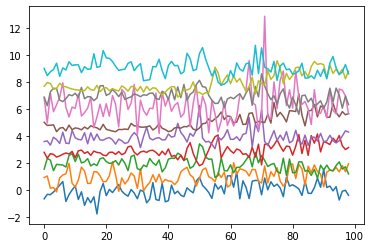

/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/140180701.py:6: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_binge_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/140180701.py:6: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_binge_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/140180701.py:6: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_binge_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/140180701.py:6: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_binge_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/140180701.py:6: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_binge_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917z15hn

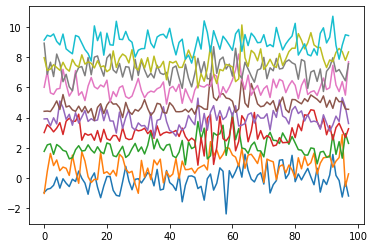

In [66]:
for i,key in enumerate(sorted(list(PETH_trace_slow_all_single_neuron.keys()))[0:10]):
    plt.plot(np.nanmean(PETH_trace_slow_all_single_neuron.get(key),axis=1)+i)
plt.show()

for i,key in enumerate(sorted(list(PETH_trace_binge_all_single_neuron.keys()))[0:10]):
    plt.plot(np.nanmean(PETH_trace_binge_all_single_neuron.get(key),axis=1)+i)
plt.show()


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/1739696803.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_slow_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/1739696803.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_slow_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/1739696803.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_slow_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/1739696803.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_slow_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/1739696803.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_slow_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917z15hn

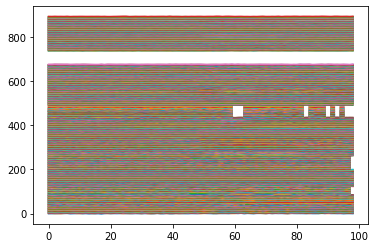

894


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/1739696803.py:7: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_binge_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/1739696803.py:7: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_binge_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/1739696803.py:7: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_binge_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/1739696803.py:7: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_binge_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/1739696803.py:7: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(PETH_trace_binge_all_single_neuron.get(key),axis=1)+i)
/var/folders/tr/w74ws6917

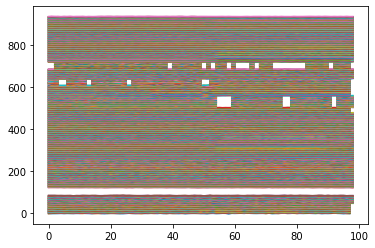

937


In [67]:

for i,key in enumerate(PETH_trace_slow_all_single_neuron.keys()):
    plt.plot(np.nanmean(PETH_trace_slow_all_single_neuron.get(key),axis=1)+i)
plt.show()
print(len(PETH_trace_slow_all_single_neuron.keys()))

for i,key in enumerate(PETH_trace_binge_all_single_neuron.keys()):
    plt.plot(np.nanmean(PETH_trace_binge_all_single_neuron.get(key),axis=1)+i)
plt.show()
print(len(PETH_trace_binge_all_single_neuron.keys()))

In [68]:
## compare mine & F's data
## load OB data and get cells that have both slow and binge responses

PSTH_trace_milk, PSTH_trace_milkbinge = [],[]

PSTH_trace_milk=loaddicti("PSTHslow_2")
PSTH_trace_milkbinge=loaddicti("PSTHfast_2")

## All cell plots with ∆F/F in slow and binge eating

new_df = pd.DataFrame()
new_dfbinge = pd.DataFrame()

empty_idx_slow = []
empty_idx_binge = []

for idx,key in enumerate(PSTH_trace_milk.keys()):
    PSTH_trace_milk[key] = PSTH_trace_milk.get(key).interpolate(limit=6) # fill nan with interpolate values, limits to 2 nans
    new_df[key]      = PSTH_trace_milk.get(key).mean(axis=1)
    # check if there is only nan values in this cell, which means no recording data avalaible
    if new_df[key].isnull().all()==True:
        empty_idx_slow.append(key)
        # print(f'empty {key}')
print(len(list(PSTH_trace_milk.keys())))
print(len(empty_idx_slow))
print('')

for idx,key in enumerate(PSTH_trace_milkbinge.keys()):
    PSTH_trace_milkbinge[key] = PSTH_trace_milkbinge.get(key).interpolate(limit=6) # fill nan with interpolate values, limits to 2 nans
    new_dfbinge[key] = PSTH_trace_milkbinge.get(key).mean(axis=1)
    # check if there is only nan values in this cell, which means no recording data avalaible
    if new_dfbinge[key].isnull().all()==True:
        empty_idx_binge.append(key)
print(len(list(PSTH_trace_milkbinge.keys())))
print(len(empty_idx_binge))
print('')

## Now remove all idxs in empty lists, so only show the neurons with both responses.
empty_idx_all = empty_idx_slow + empty_idx_binge
empty_idx_all = list(set(empty_idx_all)) # remove duplicate idx
remaining_idx = [idx for idx in new_dfbinge.columns if idx not in empty_idx_all]
remaining_idx = [idx for idx in remaining_idx if idx in new_df.columns]

print(len(empty_idx_all))
print(len(remaining_idx))

## now use the remaining idx/key for loading againg

## this is the old ones from F
PSTH_trace_milk, PSTH_trace_milkbinge = [],[]
name = 'PSTHslow'
fileo =  open("/Users/hunglo/Documents/inscopix_csv/OB_2P_data/dictionariesneurocorrzscore/"+name+".pickle", 'rb')
PSTH_trace_milk =pickle.load(fileo)

name = 'PSTHfast'
fileo =  open("/Users/hunglo/Documents/inscopix_csv/OB_2P_data/dictionariesneurocorrzscore/"+name+".pickle", 'rb')
PSTH_trace_milkbinge=pickle.load(fileo)

# PSTH_trace_milk=loaddicti("PSTHslow_2")
# PSTH_trace_milkbinge=loaddicti("PSTHfast_2")

## All cell plots with ∆F/F in slow and binge eating

new_df = pd.DataFrame()
new_dfbinge = pd.DataFrame()

empty_idx_slow = []
empty_idx_binge = []

for idx,key in enumerate(PSTH_trace_milk.keys()):
    PSTH_trace_milk[key] = PSTH_trace_milk.get(key).interpolate(limit=6) # fill nan with interpolate values, limits to 2 nans
    new_df[key]      = PSTH_trace_milk.get(key).mean(axis=1)
    # check if there is only nan values in this cell, which means no recording data avalaible
    if new_df[key].isnull().all()==True:
        empty_idx_slow.append(key)
        # print(f'empty {key}')
print(len(list(PSTH_trace_milk.keys())))
print(len(empty_idx_slow))
print('')

for idx,key in enumerate(PSTH_trace_milkbinge.keys()):
    PSTH_trace_milkbinge[key] = PSTH_trace_milkbinge.get(key).interpolate(limit=6) # fill nan with interpolate values, limits to 2 nans
    new_dfbinge[key] = PSTH_trace_milkbinge.get(key).mean(axis=1)
    # check if there is only nan values in this cell, which means no recording data avalaible
    if new_dfbinge[key].isnull().all()==True:
        empty_idx_binge.append(key)
print(len(list(PSTH_trace_milkbinge.keys())))
print(len(empty_idx_binge))
print('')

## Now remove all idxs in empty lists, so only show the neurons with both responses.
empty_idx_all = empty_idx_slow + empty_idx_binge
empty_idx_all = list(set(empty_idx_all)) # remove duplicate idx
remaining_idx_old = [idx for idx in new_dfbinge.columns if idx not in empty_idx_all]
remaining_idx_old = [idx for idx in remaining_idx_old if idx in new_df.columns]

print(len(empty_idx_all))
print(len(remaining_idx_old))

## now use the remaining idx/key for loading againg





/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/3989316329.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[key]      = PSTH_trace_milk.get(key).mean(axis=1)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/3989316329.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[key]      = PSTH_trace_milk.get(key).mean(axis=1)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/3989316329.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

894
77



/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/3989316329.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_dfbinge[key] = PSTH_trace_milkbinge.get(key).mean(axis=1)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/3989316329.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_dfbinge[key] = PSTH_trace_milkbinge.get(key).mean(axis=1)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/3989316329.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

937
44

117
752


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/3989316329.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[key]      = PSTH_trace_milk.get(key).mean(axis=1)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/3989316329.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[key]      = PSTH_trace_milk.get(key).mean(axis=1)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/3989316329.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

962
93



/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/3989316329.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_dfbinge[key] = PSTH_trace_milkbinge.get(key).mean(axis=1)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/3989316329.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_dfbinge[key] = PSTH_trace_milkbinge.get(key).mean(axis=1)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/3989316329.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

962
357

377
585


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/3989316329.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_dfbinge[key] = PSTH_trace_milkbinge.get(key).mean(axis=1)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/3989316329.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_dfbinge[key] = PSTH_trace_milkbinge.get(key).mean(axis=1)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_85950/3989316329.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

In [69]:
print(len(empty_idx_all))
print(len(remaining_idx))

print(len(empty_idx_all))
print(len(remaining_idx_old))


377
752
377
585
